# Response time minimization problem for Oslo

- Goal: Minimize the response time of police vehicles in the city of Oslo, Norway.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.
- PuLP's standard CBC solver is used to solve the problem.

Previous notebook tested the pipeline for the Oslo area. This notebook tests the method for the larger Øst police district.

Øst police district is a merger of the former Follo, Romerike and Østfold police districts. The district covers the counties of Akershus and Østfold, minus the municipalities of Asker, Bærum, Jevnaker and Lunner. The district has a population of 1.2 million people and covers an area of 10,000 km2. The district has 1,100 employees and 100 police stations. The head office is located in Ski.

In [1]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-03-16T15:41:11.299171+01:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from shapely.ops import nearest_points, unary_union
from descartes import PolygonPatch
import pyproj
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandana as pdna
import pulp

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

pandana   : 0.7
osmnx     : 1.9.1
pulp      : 2.8.0
pyproj    : 3.6.1
matplotlib: 3.8.3
networkx  : 3.2.1
shapely   : 2.0.3
numpy     : 1.26.4
pandas    : 2.2.1
geopandas : 0.14.3



## 1. Load road network of Øst police district

We load a road network of Øst police district that has been slightly preprocessed.
- Network type: drive
- Akershus and Østfold counties minus Asker, Bærum, Jevnaker and Lunner.
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633
- Network already contains edge weights (travel time in seconds)
- Node closeness centrality has already been calculated for the network and stored as a CSV file.

In [3]:
### Load road network file of Øst police district, Norway

# Read from local path
ost_filepath = "../data/ost/OstDriveImputed.graphml" # with travel time attribute
ost_graph = ox.load_graphml(ost_filepath) # originally in WGS84 (EPSG:4326)

Type of ost_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of ost_graph:  epsg:4326


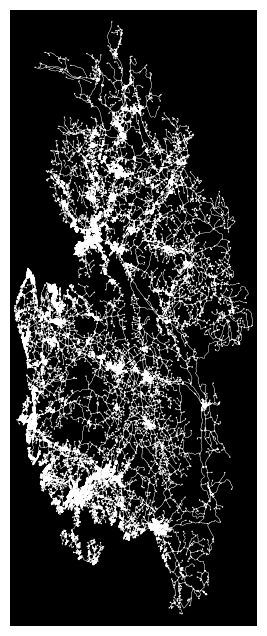

In [ ]:
# ost_graph = ox.projection.project_graph(ost_graph, to_crs='EPSG:32633') # if need to project to UTM zone 33N
print(f"Type of ost_graph: {type(ost_graph)}")
print(f"CRS of ost_graph:  {ost_graph.graph['crs']}")

# plot graph
fig, ax = ox.plot_graph(ost_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Convert graph to GeoDataFrame and plot it.   
`osmnx.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)` - Convert a MultiDiGraph to node and/or edge GeoDataFrames.

In [ ]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(ost_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
nodes.head()
# edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


,y,x,street_count,osmid,highway,ref,geometry
osmid,,,,,,,
0,59.031,11.025,3,265629056,NaN,NaN,POINT (11.02541 59.03108)
1,59.105,10.844,3,267968013,NaN,NaN,POINT (10.84353 59.10482)
2,59.105,10.843,1,267968015,NaN,NaN,POINT (10.84312 59.10492)
3,59.033,11.050,1,373193396,NaN,NaN,POINT (11.05025 59.03253)
4,59.027,11.034,3,792665177,NaN,NaN,POINT (11.03380 59.02745)


## 2. Load population data of Øst police district

We load preprocessed population data of Øst police district in 250x250m grid cells.
- Correct extent: Akershus and Østfold counties minus Asker, Bærum, Jevnaker and Lunner.
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633 before analysis.

In [ ]:
# load preprocessed population data
population_path = "../data/ost/OstPopulation.geojson"
population_df = gpd.read_file(population_path)
print(f"type of pop_df: {type(population_df)}")
print(f"columns of population_df: {population_df.columns}")
population_df.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_df: Index(['id', 'population', 'geometry'], dtype='object')


,id,population,geometry
0,22735006545750,4,"POLYGON ((11.05715 58.99115, 11.05689 58.99339..."
1,22737506546000,2,"POLYGON ((11.06123 58.99352, 11.06098 58.99576..."


## 2. Add centrality measure as node attribute

Next we load the pre-computed closeness centrality and add it as an attribute to the nodes GeoDataFrame.  

*Closeness centrality is a measure of how close a node is to all other nodes in the network.   
It is calculated as the reciprocal of the sum of the shortest path distances from the node to all other nodes in the graph.*

In [ ]:
# import node closeness centrality from file
nodes_centrality_import = pd.read_csv("../data/ost/OstNodeCentrality.csv")

# Make sure 'osmid' is set as the index in the `nodes` GeoDataFrame if it's not already
nodes.set_index('osmid', inplace=True)

# Now use the merge function. Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')

# After the merge, if you want 'osmid' as a column instead of an index, you can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.head(2)

,y,x,street_count,highway,ref,geometry,osmid,closeness_centrality
0,59.031,11.025,3,NaN,NaN,POINT (11.02541 59.03108),265629056,0.000
1,59.105,10.844,3,NaN,NaN,POINT (10.84353 59.10482),267968013,0.000


Now, that the closeness centrality is added as an attribute to the ``nodes`` GeoDataFrame, we can use this to filter out better candidate locations for the police cars.

## 3. Sample candidate points for police car locations

#### Steps:
1. Sample a set of random points from the road network.
2. Filter out points that are too close to the border of the road network (closeness centrality threshold).
3. Filter out points that are too close to each other.
4. Filter out points that are too close to the existing police stations.

In [ ]:
# random nodes from the graph
SEED = 42
NR_OF_CAR_NODES = 40
car_nodes = nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")
car_nodes.head(2)

Total nr of nodes: 8097, nr of police car nodes: 40, nr of event nodes: 970


,y,x,street_count,lon,lat,highway,ref,geometry,closeness_centrality
osmid,,,,,,,,,
3185943,6651981.230,260465.596,4,10.712,59.935,NaN,NaN,POINT (260465.596 6651981.230),0.002
1211014476,6650067.749,262823.289,2,10.756,59.920,NaN,NaN,POINT (262823.289 6650067.749),0.002


In [ ]:
# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))

def filter_and_plot_nodes_by_centrality(geo_df, top_percent, bottom_percent, input_graph, plot=False):
    """
    Filters a GeoDataFrame to find the top X% and bottom Y% of nodes based on closeness_centrality,
    optionally plots these nodes, and returns a filtered GeoDataFrame excluding the bottom Y% nodes.
    
    :param geo_df: GeoDataFrame with a 'closeness_centrality' column and 'x', 'y' for plotting.
    :param top_percent: The top percentage of nodes to select based on closeness_centrality.
    :param bottom_percent: The bottom percentage of nodes to select based on closeness_centrality.
    :param plot: Whether to plot the nodes.
    :return: A filtered GeoDataFrame excluding the bottom Y% closeness_centrality nodes.
    """
    # Calculate the number of nodes for each selection
    num_top = int(len(geo_df) * top_percent)
    num_bottom = int(len(geo_df) * bottom_percent)
    
    # Sort the DataFrame by closeness_centrality
    sorted_geo_df = geo_df.sort_values(by='closeness_centrality', ascending=False)
    
    # Select the top X% and bottom Y%
    central_car_nodes = sorted_geo_df.head(num_top)
    remote_car_nodes = sorted_geo_df.tail(num_bottom)
    
    # print(f"Selection of {top_percent*100}% highest and {bottom_percent*100}% lowest closeness centrality car nodes\nTotal nr of nodes: {len(sorted_geo_df)}\nNr of remote car nodes: {len(remote_car_nodes)},\nNr of central car nodes: {len(central_car_nodes)}")
    

    print(f"Input nr of car nodes: {len(geo_df)}")
    print(f"Remaining nr of car nodes: {len(sorted_geo_df) - len(remote_car_nodes)}, after discarding the {len(remote_car_nodes)} ({bottom_percent*100:.0f}%) remote car nodes with lowest closeness centrality\n")
    if plot:
        # Plot all nodes
        fig, ax = ox.plot_graph(input_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False)
        ax.scatter(geo_df['x'], geo_df['y'], c='white', s=50, label="Input Car nodes")
        ax.scatter(central_car_nodes['x'], central_car_nodes['y'], c='orange', s=50, label=f"Highest {top_percent*100:.0f}% centrality")
        ax.scatter(remote_car_nodes['x'], remote_car_nodes['y'], c='red', s=50, label=f"Lowest {bottom_percent*100:.0f}% centrality")
        ax.legend()
        plt.show()
    
    # Remove the bottom Y% nodes from the original GeoDataFrame
    filtered_geo_df = sorted_geo_df.drop(remote_car_nodes.index)
    return filtered_geo_df

car_nodes_gdf_central = filter_and_plot_nodes_by_centrality(geo_df=car_nodes_gdf, top_percent=0.5, bottom_percent=0.20, input_graph=oslo_graph, plot=True)

In [ ]:
def filter_nodes_by_proximity(geo_df, min_distance, input_graph, criterion_col=None, prefer='higher', plot=False):
    """
    Removes nodes from a GeoDataFrame that are within a specified minimum distance of each other.
    
    :param geo_df: GeoDataFrame with a 'geometry' column.
    :param min_distance: Minimum distance in the GeoDataFrame's coordinate reference system units.
    :param input_graph: The graph from which the nodes were extracted, used for plotting.
    :param criterion_col: Column name to use as a criterion for removing nodes. Optional.
    :param prefer: Determines which node to keep based on the criterion_col ('higher' or 'lower').
    :param plot: Whether to plot the nodes.
    :return: A filtered GeoDataFrame excluding nodes within the minimum distance of each other.
    """
    sindex = geo_df.sindex # Create a spatial index for the GeoDataFrame
    to_remove = [] # List to keep track of indices to remove
    
    # Iterate over the GeoDataFrame
    for index, row in geo_df.iterrows():
        # Create a buffer around the geometry and find potential matches using the spatial index
        buffer = row.geometry.buffer(min_distance)
        possible_matches_index = list(sindex.intersection(buffer.bounds))
        possible_matches = geo_df.iloc[possible_matches_index]
        
        # Actual neighbors are those within the specified distance, excluding the row itself
        actual_neighbors = possible_matches[possible_matches.distance(row.geometry) < min_distance]
        actual_neighbors = actual_neighbors.drop(index, errors='ignore')
        
        for neighbor_index, neighbor in actual_neighbors.iterrows():
            if criterion_col:
                # Decide which node to remove based on the criterion
                if (prefer == 'higher' and neighbor[criterion_col] > row[criterion_col]) or \
                   (prefer == 'lower' and neighbor[criterion_col] < row[criterion_col]):
                    to_remove.append(index)
                    break  # Current node will be removed, no need to check other neighbors
                else:
                    to_remove.append(neighbor_index)
            else:
                # If no criterion is given, default to removing the neighbor
                to_remove.append(neighbor_index)
    
    # Remove duplicates and drop the nodes
    to_remove = list(set(to_remove))
    filtered_geo_df = geo_df.drop(index=to_remove)
    
    # Reset index to clean up the DataFrame
    filtered_geo_df.reset_index(drop=True, inplace=True)

    print(f"Input nr of car nodes: {len(geo_df)}")
    print(f"Remaining nr of car nodes: {len(geo_df) - len(to_remove)}, after removing the {len(to_remove)} nodes that are within {min_distance} m of each other\n")

    if plot:
        # Plot all nodes
        fig, ax = ox.plot_graph(input_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False)
        ax.scatter(geo_df.loc[to_remove, 'x'], geo_df.loc[to_remove, 'y'], c='red', s=50, label="Removed car nodes")
        ax.scatter(filtered_geo_df['x'], filtered_geo_df['y'], c='orange', s=50, label=f"Remaining car nodes")
        ax.legend(); plt.show()
    return filtered_geo_df

car_nodes_gdf_filtered = filter_nodes_by_proximity(geo_df=car_nodes_gdf_central, min_distance=1300, input_graph=oslo_graph, criterion_col='closeness_centrality', prefer='higher', plot=True)